In [6]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Submit to NeurIPS.

Main functions are `BayesianIsingModel` and `BayesianIsingMixtures`.

See the simulation section and NLTCS data section on how to use them.

In [34]:
import torch
import time
import itertools
import numpy as np
from numpy.linalg import inv
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.optimize import HessianUpdateStrategy
import matplotlib.pyplot as plt
import networkx as nx
import warnings
from scipy.stats import chisquare
from scipy.stats import chi2
import random
import torch
import torch.nn as nn 
import torch.optim as optim
import scipy
import pandas as pd
warnings.filterwarnings("ignore", message="delta_grad == 0.0. Check if the approximated function is linear.")
#import warnings
#warnings.simplefilter("error", RuntimeWarning)
def structure_constants(d,interaction_level=2):
    I=np.zeros((2**d,d),dtype=np.int8)
    I_len=I.shape[0]
    i=1
    j=1
    while i < I_len:
        it=itertools.combinations(range(d),j)
        for it_index in it:
            I[i,it_index]=1
            i+=1
        j+=1
    J=np.asarray([i for i in I if 0<np.sum(i)<=interaction_level])
    J_len=J.shape[0]
    A_transpose=[]
    for i in I:
        f_i=[]
        for j_index in range(J_len):
            if -1 in i-J[j_index]:
                f_i.append(0)
            else:
                f_i.append(1)
        A_transpose.append(f_i)
    A_transpose=np.asarray(A_transpose)
    A=np.transpose(A_transpose)
    return I,I_len,J,J_len,A,A_transpose
def data_p(theta,A_transpose):
    theta=np.asarray(theta)
    return np.exp(np.matmul(A_transpose,theta)-np.log(np.sum(np.exp(np.matmul(A_transpose,theta)))))
def data_p_mixture(d,A,para):
    para=np.asarray(para)
    return para[0]*data_p(para[1:(1+A.shape[0])],np.transpose(A))+(1-para[0])*data_p(para[np.concatenate((1+np.arange(d),1+A.shape[0]+np.arange(A.shape[0]-d)))],np.transpose(A))
def r(theta,v_0=0.1,v_1=1,beta=0.5):
    theta=np.asarray(theta)
    return 1/(1+(1-beta)*v_1/(v_0*beta)*np.exp(theta**2*(1/v_1**2-1/v_0**2)/2))
def BayesianIsingModel(N,n_obs,A,d,n_samples=10**5,v_0=0.1,v_1=1,beta=0.5):
    def tilde_ell_20(theta):
        return N*np.log(np.sum(np.exp(np.matmul(np.transpose(A),theta)),0))-np.matmul(np.transpose(theta),np.matmul(A,n_obs))+np.sum(theta**2,0)/(2*v_1**2)
    def tilde_ell_20_gradient(theta):
        temp=np.exp(np.matmul(np.transpose(A),theta))
        return N*np.matmul(A,temp)/np.sum(temp)-np.matmul(A,n_obs)+theta/v_1**2
    def tilde_ell_20_Hessian(theta):
        J_len=A.shape[0]
        I_len=A.shape[1]
        temp=np.exp(np.matmul(theta,A))
        temp_sum=np.sum(temp)
        temp1=A*np.reshape(np.sqrt(temp),[1,I_len])
        part1=N*np.matmul(temp1,np.transpose(temp1))/temp_sum
        part2_1=np.reshape(np.matmul(A,temp),[J_len,1])
        part2=N*np.matmul(part2_1,np.transpose(part2_1))/temp_sum**2
        return part1-part2+np.identity(J_len)/v_1**2
    
    J_len=A.shape[0]
    minimize_res=minimize(tilde_ell_20,np.asarray([0]*J_len),jac=tilde_ell_20_gradient)
    tilde_theta=minimize_res.x
    tilde_H=tilde_ell_20_Hessian(tilde_theta)
    theta_samples=np.transpose(np.random.multivariate_normal(tilde_theta,inv(tilde_H),n_samples))
    tilde_ell_vals=tilde_ell_20(theta_samples)
    h_12_val=np.exp(-tilde_ell_vals+np.min(tilde_ell_vals)+np.sum(np.matmul(tilde_H,theta_samples-tilde_theta.reshape([J_len,1]))*(theta_samples-tilde_theta.reshape([J_len,1])),0)/2)*np.prod((1-beta)*v_1/(v_0*beta)*np.exp(theta_samples[d:,:]**2*(1/(2*v_1**2)-1/(2*v_0**2)))+1,0)
    h_12_val=h_12_val/np.sum(h_12_val)
    #### Returning posterior mean of association indicators gamma
    return np.sum(r(theta_samples,v_0,v_1,beta)*h_12_val,1)[d:]
def BayesianIsingMixtures(N,n_obs,A,d,n_samples=10**5,v_0=0.1,v_1=1,beta=0.5,alpha_1=1,alpha_2=1):
    #Two components ONLY
    #Same main effects
    ###############Generating theta_samples
    class myLoss_random(nn.Module): 
        def __init__(self):
            super().__init__()
            self.w_torch = nn.Parameter(torch.tensor(.5)) 
            self.theta_torch = nn.Parameter(torch.from_numpy(np.float64(0.1*np.random.normal(size=d**2))))
        def forward(self,A_torch, n_obs_torch, v_1=torch.tensor(1.0)):
            log_temp1=torch.matmul(self.theta_torch[:A_torch.shape[0]],A_torch)
            temp1=torch.exp(log_temp1-torch.max(log_temp1))
            log_temp2=torch.matmul(self.theta_torch[np.concatenate((np.arange(d),A_torch.shape[0]+np.arange(A_torch.shape[0]-d)))],A_torch)
            temp2=torch.exp(log_temp2-torch.max(log_temp2))
            return -torch.sum(n_obs_torch*torch.log(self.w_torch*temp1/torch.sum(temp1)+(1-self.w_torch)*temp2/torch.sum(temp2)))

    n_obs_torch=torch.from_numpy(np.float64(n_obs))
    A_torch=torch.from_numpy(np.float64(A))

    n_Mode=5
    w_ModeList=np.zeros(n_Mode)
    theta_ModeList=np.zeros((d**2,n_Mode))
    log_l_ModeList=np.zeros(n_Mode)
    h_18_hess_ModeList=np.zeros((n_Mode,d**2,d**2))
    h_18_inv_hess_ModeList=np.zeros((n_Mode,d**2,d**2))
    i=0
    while i<n_Mode:
        model = myLoss_random()
        optimizer = optim.Adam(model.parameters()) 
        epoch = 0
        e_list=[]
        while epoch<50000:
            optimizer.zero_grad()
            e = model(A_torch,n_obs_torch)
            e.backward()
            e_list.append(e)
            optimizer.step()
            epoch += 1
            if epoch>2 and abs(e_list[-2].detach().numpy()-e_list[-1].detach().numpy())<1e-9:
                break
        w_ModeList[i]=model.w_torch.detach().numpy()
        theta_ModeList[:,i]=model.theta_torch.detach().numpy()
        log_l_ModeList[i]=-e_list[-1].detach().numpy()
        if w_ModeList[i]>.5:
            w_ModeList[i]=1-w_ModeList[i]
            temp1=theta_ModeList[d:A.shape[0],i]
            temp2=theta_ModeList[A.shape[0]:,i]
            theta_ModeList[d:A.shape[0],i],theta_ModeList[A.shape[0]:,i]=theta_ModeList[A.shape[0]:,i],theta_ModeList[d:A.shape[0],i]

        ####Checking whether not positive definite
        w_mode=w_ModeList[i]
        w_mode_torch=torch.tensor(w_mode)
        theta_mode=theta_ModeList[:,i]
        theta_mode_torch=torch.from_numpy(np.float64(theta_mode))

        def h18_known_w_torch(theta_torch):
            log_temp1=torch.matmul(theta_torch[:A.shape[0]],A_torch)
            temp1=torch.exp(log_temp1-torch.max(log_temp1))
            log_temp2=torch.matmul(theta_torch[np.concatenate((np.arange(d),A.shape[0]+np.arange(A.shape[0]-d)))],A_torch)
            temp2=torch.exp(log_temp2-torch.max(log_temp2))
            return -torch.sum(n_obs_torch/torch.sum(n_obs_torch)*torch.log(w_mode_torch*temp1/torch.sum(temp1)+(1-w_mode_torch)*temp2/torch.sum(temp2)))#+torch.sum(theta_torch**2)/(2*torch.sum(n_obs_torch)*v_1**2)

        h_18_hess_torch=torch.autograd.functional.hessian(h18_known_w_torch,theta_mode_torch)
        h_18_hess=h_18_hess_torch.numpy()
        h_18_inv_hess=inv(h_18_hess)
        
        h_18_hess_ModeList[i,:,:]=h_18_hess*np.sum(n_obs)
        h_18_inv_hess_ModeList[i,:,:]=h_18_inv_hess/np.sum(n_obs)

        if (w_mode>0) and (w_mode<1) and np.all(np.linalg.eigvals(h_18_hess)>1e-10):
            i=i+1
#         print(i)

    #######Preparing vectors for samples
    component_weights=np.exp(log_l_ModeList-max(log_l_ModeList))/sum(np.exp(log_l_ModeList-max(log_l_ModeList)))
    n_samples_components=np.round(n_samples*component_weights)
    n_samples_components=np.asarray([int(temp) for temp in n_samples_components])
    n_samples=int(sum(n_samples_components))
    w_samples=np.zeros(n_samples)
    theta_samples=np.zeros((d*(d-1)+d,n_samples))
    log_weights_IS=np.zeros(n_samples)
    ###Sampling
    for i in range(n_Mode):
        n_sample=int(n_samples_components[i])
        w_mode=w_ModeList[i]
        w_mode_torch=torch.tensor(w_mode)
        theta_mode=theta_ModeList[:,i]
        h_18_hess=h_18_hess_ModeList[i,:,:]
        h_18_inv_hess=h_18_inv_hess_ModeList[i,:,:]

        ###Sampling theta
        theta_sample=np.transpose(np.random.multivariate_normal(theta_mode,h_18_inv_hess,n_sample))
        theta_samples[:,int(sum(n_samples_components[:i])):int(sum(n_samples_components[:(i+1)]))]=theta_sample

    ####Sampling w
    w_samples=np.concatenate([np.random.dirichlet((N*w_ModeList[temp]+1,N*(1-w_ModeList[temp])+1),n_samples_components[temp])[:,0] for temp in range(n_Mode)])
    ####Computing the weights
    ##Weights from theta
    log_temp1=np.matmul(np.transpose(A),theta_samples[:A.shape[0],:])
    temp1=np.exp(log_temp1-np.max(log_temp1,0))
    log_temp2=np.matmul(np.transpose(A),theta_samples[np.concatenate((np.arange(d),A.shape[0]+np.arange(A.shape[0]-d))),:])
    temp2=np.exp(log_temp2-np.max(log_temp2,0))
    N_tilde_ell=np.matmul(n_obs,np.log(w_samples*temp1/np.sum(temp1,0)+(1-w_samples)*temp2/np.sum(temp2,0)))-np.sum(theta_samples**2,0)/(2*v_1**2)
    log_obj=N_tilde_ell+np.sum(np.log((1-beta)*v_1/(v_0*beta)*np.exp(theta_samples[d:,:]**2*(1/(2*v_1**2)-1/(2*v_0**2)))+1),0)+(alpha_1-1)*np.log(w_samples)+(alpha_2-1)*np.log(1-w_samples)
    theta_dev_samples=np.asarray([theta_samples-theta_ModeList[:,i].reshape([theta_ModeList.shape[0],1]) for i in range(n_Mode)])
    log_sampling=(-np.log(np.linalg.det(h_18_inv_hess_ModeList))/2).reshape([n_Mode,1])-np.sum(np.matmul(h_18_hess_ModeList,theta_dev_samples)*theta_dev_samples,1)/2
    ##Weights from w
    alpha_1_hat=np.asarray([[N*(w_ModeList[temp])+1]*n_samples for temp in range(n_Mode)])
    alpha_2_hat=np.asarray([[N*(1-w_ModeList[temp])+1]*n_samples for temp in range(n_Mode)])

    ##Combine weights
    log_sampling=log_sampling+scipy.special.loggamma(alpha_1_hat+alpha_2_hat)-scipy.special.loggamma(alpha_1_hat)-scipy.special.loggamma(alpha_2_hat)+(alpha_1_hat-1)*np.log(w_samples)+(alpha_2_hat-1)*np.log(1-w_samples)
    log_sampling=log_sampling+np.log(component_weights).reshape([n_Mode,1])
    log_sampling=np.log(np.sum(np.exp(log_sampling-np.max(log_sampling)),0))+np.max(log_sampling)

    log_weights_IS=log_obj-log_sampling
    ####Output weights
    index=(log_weights_IS!=0) & (log_weights_IS!=np.inf) & (np.isnan(log_weights_IS)==False)
    temp_weights=np.exp(log_weights_IS[index]-max(log_weights_IS[index]))
    temp_weights=temp_weights/sum(temp_weights)
    posteriorGamma=np.matmul(r(theta_samples[:,index]),temp_weights)[d:]
    posteriorW=np.sum(w_samples[index]*temp_weights)
    #### Returning posterior mean of association indicators Gamma and weights W
    return [posteriorGamma,posteriorW]

def create_graph(file_name,interaction_res,non_zero_edges,non_zero_edge_weights,common_edges,difference_edges):
    G = nx.Graph()
    for k in range(int((1+np.sqrt(1+8*len(interaction_res)))/2)):
        G.add_node(k+1)
    for k in range(len(non_zero_edges)):
        G.add_edge(non_zero_edges[k][0], non_zero_edges[k][1], weight=non_zero_edge_weights[k])
    pos=nx.circular_layout(G)
    options = {
#         "font_size": 20,
        "node_size": 600,
        "node_color": "white",
        "edgecolors": "black",
        "linewidths": 2,
#         "width": 2,
    }
#     nx.draw_networkx(G, pos, **options)
    nx.draw_networkx_nodes(G, pos, **options)
#     nx.draw_networkx_nodes(G, pos, node_size=600, node_color='white',linewidths=2)
    nx.draw_networkx_edges(
        G, pos, edgelist=common_edges, width=2, alpha=0.2, edge_color="b", style="solid"
    )
    nx.draw_networkx_edges(
        G, pos, edgelist=difference_edges, width=2, alpha=0.2, edge_color="r", style="dashed"
    )
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    nx.draw_networkx_edge_labels(G, pos, nx.get_edge_attributes(G, "weight"))
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.savefig('figures/'+file_name+'.pdf')
    plt.show()
def interactionToEdges(interaction_res,d):
    k=0
    non_zero_edges=[]
    non_zero_edge_weights=[]
    for i in range(d-1):
        for j in range(i+1,d):
            if interaction_res[k]>0.5:
                non_zero_edges.append((i+1,j+1))
                non_zero_edge_weights.append(np.round(interaction_res[k],2))
            k+=1
    return non_zero_edges,non_zero_edge_weights

### Simulation results for two components

In [35]:
d=6
I,I_len,J,J_len,A,A_transpose=structure_constants(d,2)

main_1=[1,-1,1,-1,1,-1]
interaction_1=[1,-1,0,0,0,1,0,0,0,0,0,0,0,0,0]
theta_1=np.asarray(main_1+interaction_1)

main_2=[1,-1,1,-1,1,-1]
interaction_2=[0,0,1,-1,0,0,0,0,0,0,0,0,0,0,0]
theta_2=np.asarray(main_2+interaction_2)

N=10**4
w_1=0.4
p_population=w_1*data_p(theta_1,A_transpose)+(1-w_1)*data_p(theta_2,A_transpose)
n_obs=N*p_population

In [36]:
res1=BayesianIsingModel(N,n_obs,A,d)
res_Gamma,res_w=BayesianIsingMixtures(N,n_obs,A,d)

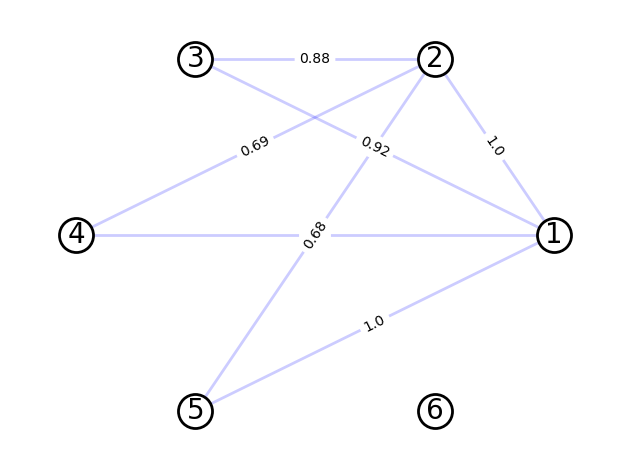

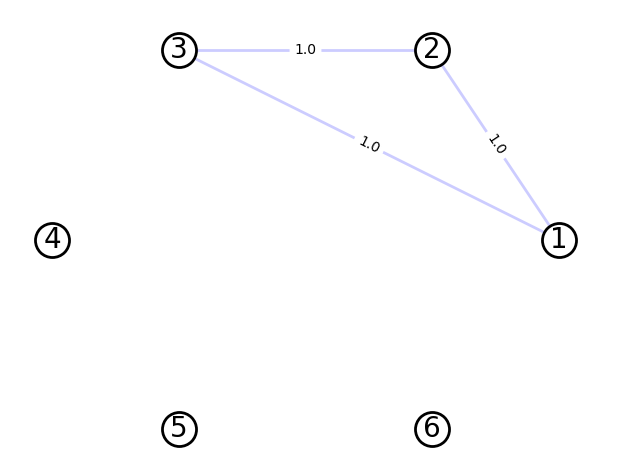

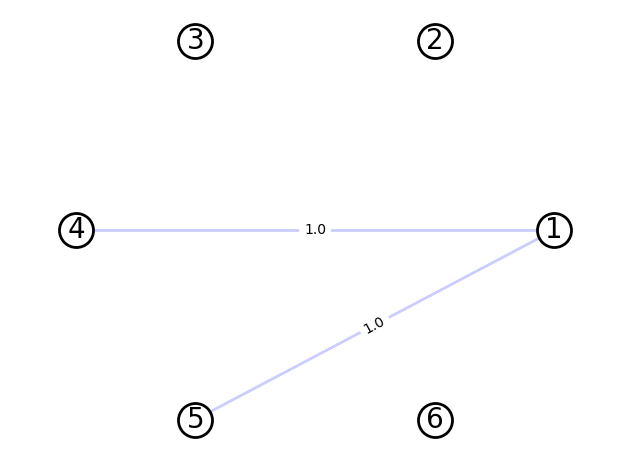

In [37]:
interaction_res1=res1
interaction_res2_C1=res_Gamma[:(d*(d-1)//2)]
interaction_res2_C2=res_Gamma[(d*(d-1)//2):]


non_zero_edges1,non_zero_edge_weights1=interactionToEdges(interaction_res1,d)
non_zero_edges2_C1,non_zero_edge_weights2_C1=interactionToEdges(interaction_res2_C1,d)
non_zero_edges2_C2,non_zero_edge_weights2_C2=interactionToEdges(interaction_res2_C2,d)

common_edges=set(non_zero_edges1)
difference_edges1=set(non_zero_edges1).difference(common_edges)


common_edges2_C1=set(common_edges).intersection(non_zero_edges2_C1)
difference_edges2_C1=set(non_zero_edges2_C1).difference(common_edges)

common_edges2_C2=set(common_edges).intersection(non_zero_edges2_C2)
difference_edges2_C2=set(non_zero_edges2_C2).difference(common_edges)

create_graph('DesignDbeta50IsingEdges',interaction_res1,non_zero_edges1,non_zero_edge_weights1,common_edges,difference_edges1)
create_graph('DesignDbeta50IsingMixture1Edges_mixture',interaction_res2_C1,non_zero_edges2_C1,non_zero_edge_weights2_C1,common_edges2_C1,difference_edges2_C1)
create_graph('DesignDbeta50IsingMixture2Edges_mixture',interaction_res2_C2,non_zero_edges2_C2,non_zero_edge_weights2_C2,common_edges2_C2,difference_edges2_C2)

### NLTCS Data

In [44]:
data_nltcs=np.loadtxt('NLTCS.txt',dtype=np.intc)
N,d=data_nltcs.shape
I,I_len,J,J_len,A,A_transpose=structure_constants(d,2)
n_obs=np.zeros(I_len,dtype=np.intc)
j2=0
for j1 in range(N):
    while not np.array_equal(I[j2],data_nltcs[j1]):
        j2=(j2+1)%I_len
    n_obs[j2]+=1
n_obs

array([4419,   97,   67,  472, 2063,   55,  335,   44,  313,   18,   33,
         76,    1,    5,    2,    6,  119,  115,    1,   16,    0,    4,
       1189,   17,  112,    6,  130,   64,  529,   52,  453,   56,    2,
         22,   13,  116,   10,   67,   47,    0,    2,    0,    1,   92,
          0,    4,    0,    4,    1,   12,    5,   19,    1,    0,    0,
          3,    1,    0,  354,    2,   27,    4,   16,    5,   55,    3,
         24,    1,    0,    0,    1,    7,    1,   60,  667,   29,  601,
         14,    1,   16,    3,   55,    8,   85,    7,   65,   69,  400,
         24,    5,   62,    2,   10,  164,    0,    8,    2,    6,    3,
         15,    3,    5,    0,    0,    0,    0,    0,    0,    3,   32,
          4,   41,    1,    0,    1,    0,    1,    0,    4,    1,    3,
          3,    9,    0,    0,    0,    0,    0,   14,  226,   11,  140,
          5,    0,    2,    2,   10,    0,    7,    3,    3,   11,   31,
          3,    0,    4,    0,    2,  125,    8,  1

In [45]:
res1=BayesianIsingModel(N,n_obs,A,d)
res_Gamma,res_w=BayesianIsingMixtures(N,n_obs,A,d)

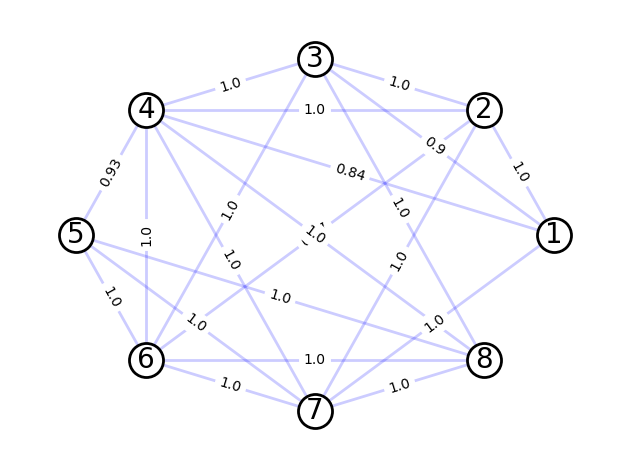

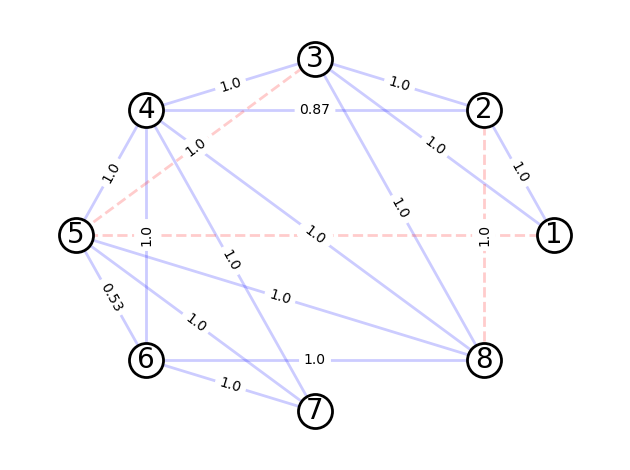

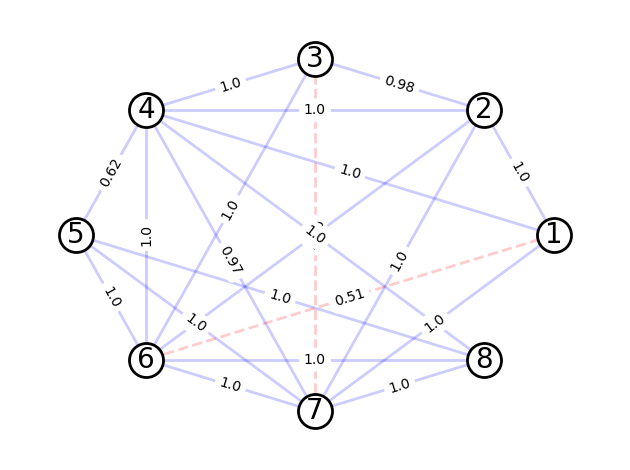

In [46]:
interaction_res1=res1
interaction_res2_C1=res_Gamma[:(d*(d-1)//2)]
interaction_res2_C2=res_Gamma[(d*(d-1)//2):]


non_zero_edges1,non_zero_edge_weights1=interactionToEdges(interaction_res1,d)
non_zero_edges2_C1,non_zero_edge_weights2_C1=interactionToEdges(interaction_res2_C1,d)
non_zero_edges2_C2,non_zero_edge_weights2_C2=interactionToEdges(interaction_res2_C2,d)

common_edges=set(non_zero_edges1)
difference_edges1=set(non_zero_edges1).difference(common_edges)


common_edges2_C1=set(common_edges).intersection(non_zero_edges2_C1)
difference_edges2_C1=set(non_zero_edges2_C1).difference(common_edges)

common_edges2_C2=set(common_edges).intersection(non_zero_edges2_C2)
difference_edges2_C2=set(non_zero_edges2_C2).difference(common_edges)

create_graph('NLTCSbeta50IsingEdges',interaction_res1,non_zero_edges1,non_zero_edge_weights1,common_edges,difference_edges1)
create_graph('NLTCSbeta50IsingMixture1Edges_mixture',interaction_res2_C1,non_zero_edges2_C1,non_zero_edge_weights2_C1,common_edges2_C1,difference_edges2_C1)
create_graph('NLTCSbeta50IsingMixture2Edges_mixture',interaction_res2_C2,non_zero_edges2_C2,non_zero_edge_weights2_C2,common_edges2_C2,difference_edges2_C2)

